Loaded image shape: (57, 101)
First 10 values: [0.0001848  0.00077001 0.00067761 0.00077001 0.00092402 0.00141682
 0.00107802 0.00129362 0.00806973 0.02192996]
Available PET series:
  Series UID: 2.16.840.1.114362.1.12192385.26916398793.697132191.975.827 with volume shape: (669, 256, 256)
---- SUV Conversion Debug Info ----
Max Rescale Slope  : 9.04428
Max Rescale Slope  : 0.4930678983258595
Max Rescale Intercept: 0.0
Radionuclide Total Dose (Bq): 202190000.0
Radionuclide Half-Life (s): 6586.2001953125
Injection Time: 2025-02-12 08:15:00
Series Time: 2025-02-12 09:19:00
Patient Weight (kg): 102.0
Decay Correction Factor: 0.6675569187849013
Max activity concentration (Bq/ml): 296353.92276000004
Corrected Dose (Bq): 134973333.4091192
Max SUV value calculated: 223.95609086644745
------------------------------------
SUV volume shape: (669, 256, 256)
SUV Statistics:
  Mean SUV: 0.10017151184397956
  Max SUV: 223.95609086644745
  Min SUV: 0.0
Original Spacing: (2.734375, 2.734375, 2.79)
Orig

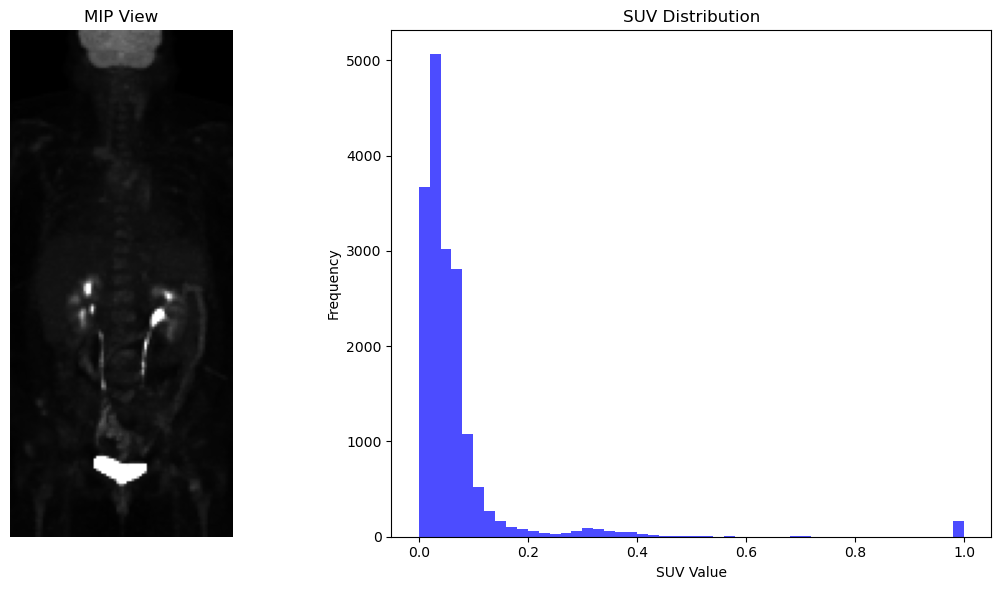

(200, 88)


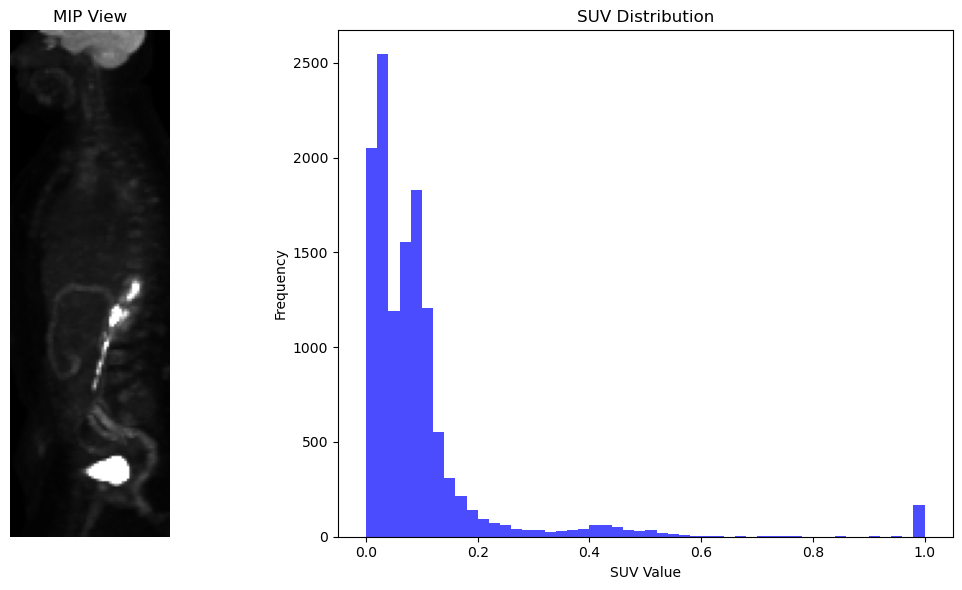

(200, 63)
---- SUV Conversion Debug Info ----
Max Rescale Slope  : 9.04428
Max Rescale Slope  : 0.4930678983258595
Max Rescale Intercept: 0.0
Radionuclide Total Dose (Bq): 202190000.0
Radionuclide Half-Life (s): 6586.2001953125
Injection Time: 2025-02-12 08:15:00
Series Time: 2025-02-12 09:19:00
Patient Weight (kg): 102.0
Decay Correction Factor: 0.6675569187849013
Max activity concentration (Bq/ml): 296353.92276000004
Corrected Dose (Bq): 134973333.4091192
Max SUV value calculated: 223.95609086644745
------------------------------------
SUV volume shape: (669, 256, 256)
Original Spacing: (2.734375, 2.734375, 2.79)
Original Size: (256, 256, 669)
New Spacing: [4, 4, 4]
Computed New Size: [175, 175, 467]
Resampled Size: (467, 175, 175)


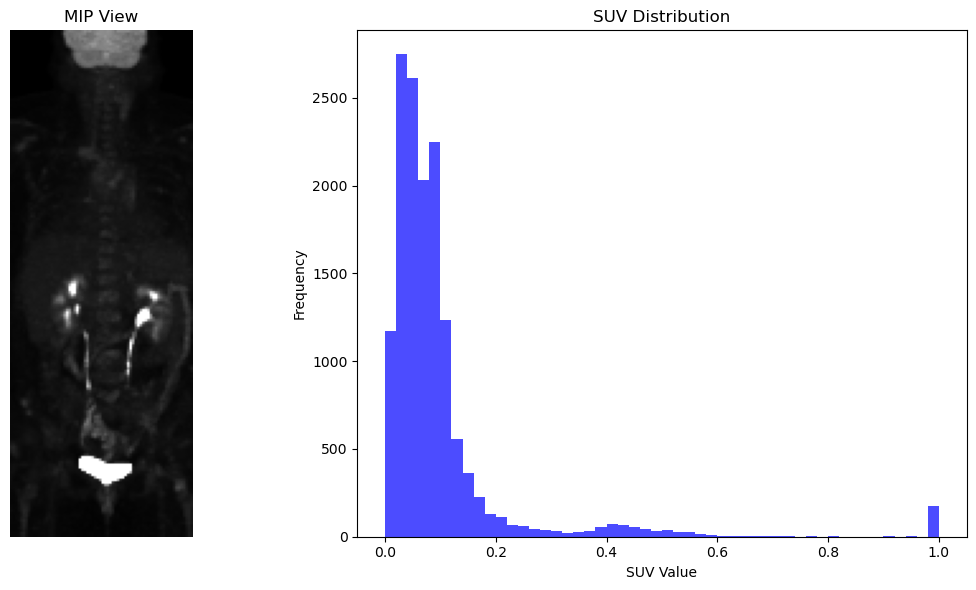

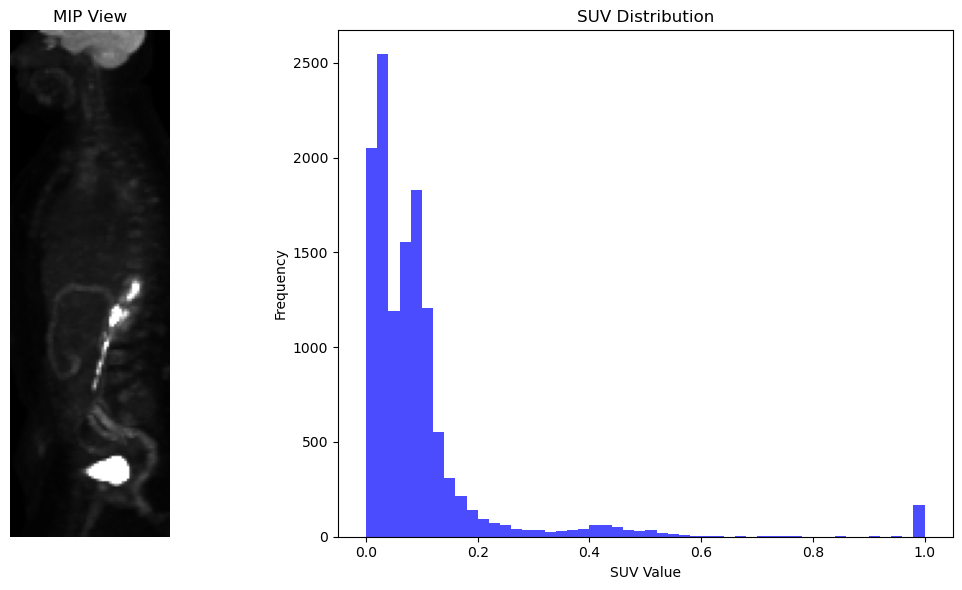

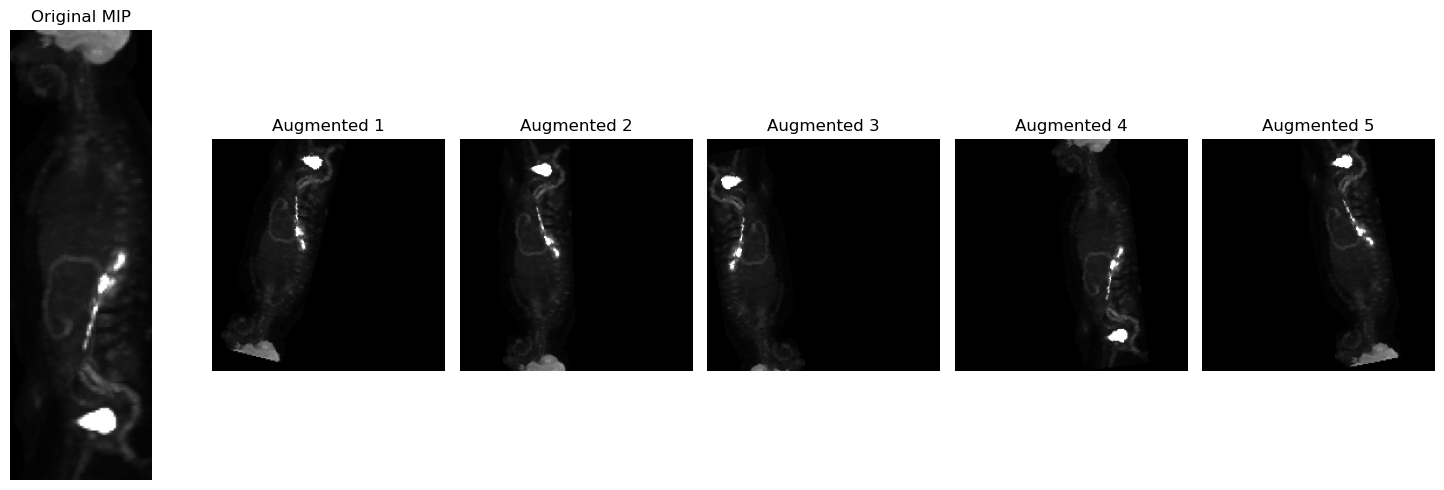

In [1]:
import os
from collections import defaultdict
import pandas as pd
import pydicom
import import_ipynb
from prepro_PET import *  # Imports all functions from prepro_PET.ipynb
import numpy as np

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [2]:
import os

data_path_img = "C:/Users/alime/Dropbox (AMC)/Mon PC (DESKTOP-RG9FHVT)/Desktop/Deauville/Deauville_DeepLearning/images"

print("✅ Listing first 10 files in dataset folder:")
print(os.listdir(data_path_img)[:10])  # Show first 10 files



✅ Listing first 10 files in dataset folder:
['00000056_1.2.840.113619.2.2920.1234.16928389305.3121207.npy', '00000056_1.2.840.113619.2.604.1234.51773156463.4572937.npy', '00000056_1.2.840.113619.2.6554.1234.8970309374.4132273.npy', '00000056_1.2.840.113619.2.8013.1234.8118932966.2036263.npy', '00000076_1.2.840.113619.2.9142.1234.18657598175.5017693.npy', '00000078_1.2.840.113619.2.3617.1234.76063953110.1516064.npy', '00000078_1.2.840.113619.2.8510.1234.41053262397.6931932.npy', '00000079_1.2.840.113619.2.2127.1234.39145274190.8561793.npy', '00000079_1.2.840.113619.2.791.1234.91718045572.3730455.npy', '00000079_1.2.840.113619.2.9006.1234.62072787418.9018305.npy']


In [3]:
# ---------------------------
# 1. Loading the PET Series
# ---------------------------
def load_pet_series(modality_path):
    """
    Load all PET DICOM files from a modality folder, group them by SeriesInstanceUID,
    sort by InstanceNumber, and stack them into a 3D NumPy array.
    
    Parameters:
      modality_path (str): Path to the PET DICOM folder.
    
    Returns:
      dict: Mapping from series UID to a dict containing:
            - 'volume': 3D NumPy array (unsorted raw pixel data)
            - 'metadata': A representative DICOM dataset (from the first slice)
    """
    
    series_dict = defaultdict(list)
    # We now keep the entire list of DICOM slices for each series.
    if not os.path.exists(modality_path):
        print(f"❌ ERROR: Folder '{modality_path}' does not exist!")
        return {}
    
    files = os.listdir(modality_path)
    for file in files:
        file_path = os.path.join(modality_path, file)
        if os.path.isfile(file_path):
            try:
                ds = pydicom.dcmread(file_path)
                # Extract SeriesInstanceUID
                series_id = ds.get("SeriesInstanceUID", None)
                if series_id is None:
                    continue
                series_dict[series_id].append(ds)
            except Exception as e:
                print(f"❌ ERROR reading {file_path}: {e}")
    
    # Convert series_dict to stacked NumPy arrays and store full list of slices
    series_volumes = {}
    for series_id, ds_list in series_dict.items():
        ds_list.sort(key=lambda s: int(s.get("InstanceNumber", 0)))
        try:
            volume = np.stack([s.pixel_array for s in ds_list])
            series_volumes[series_id] = {"volume": volume, "metadata_list": ds_list}
        except Exception as e:
            print(f"❌ ERROR stacking slices for series {series_id}: {e}")
    return series_volumes

In [4]:
# ---------------------------
# 2. Loading PET Study Data from a Study Folder
# ---------------------------
def load_pet_study(study_path, modality_name="QClear 550_DICOM"):
    """
    Load the PET series from a study folder by looking for a subfolder with the given modality name.
    
    Parameters:
        study_path (str): Path to the study folder.
        modality_name (str): The name of the PET modality folder (default: "QClear 550_DICOM").
    
    Returns:
        dict: Mapping from series UID to PET series data if the modality folder exists;
              otherwise, an empty dict.
    """
    modality_folder = os.path.join(study_path, modality_name)
    if os.path.isdir(modality_folder):
        print(f"Found modality folder: {modality_folder}")
        return load_pet_series(modality_folder)
    else:
        print(f"Modality folder '{modality_name}' not found in {study_path}")
        return {}

In [5]:
# ---------------------------
# 3. Loading Patient Data: Traverse Studies and PET Series
# ---------------------------
def load_patient_data(patient_path):
    """
    Load all studies and their respective PET series for a given patient.
    
    Parameters:
        patient_path (str): Path to the patient folder (e.g., '.../00000105').
    
    Returns:
        dict: Nested dictionary where keys are study folder names and values are the output of load_pet_study.
    """
    patient_data = {}
    for study in os.listdir(patient_path):
        study_path = os.path.join(patient_path, study)
        if os.path.isdir(study_path):
            print(f"Processing study folder: {study_path}")
            study_pet_data = load_pet_study(study_path)
            if study_pet_data:  # Only add if PET data is found
                patient_data[study] = study_pet_data
    return patient_data


In [6]:
# 2. Loading All Patients Data from a Directory
# ---------------------------
def load_all_patients_data(data_dir):
    """
    Load the PET data for all patients in a given directory.
    
    Parameters:
        data_dir (str): Directory containing patient folders.
        
    Returns:
        dict: A dictionary where keys are patient IDs (folder names) and values are the output of load_patient_data.
    """
    all_patient_data = {}
    for patient_folder in os.listdir(data_dir):
        patient_path = os.path.join(data_dir, patient_folder)
        if os.path.isdir(patient_path):
            print(f"Loading data for patient: {patient_folder}")
            patient_data = load_patient_data(patient_path)
            if patient_data:
                all_patient_data[patient_folder] = patient_data
    return all_patient_data

In [7]:
def split_patients(all_patient_data, test_ratio=0.2):
    """
    Split the patients at the patient level into a training/tuning set and a held-out test set.
    
    Parameters:
        all_patient_data (dict): Output from load_all_patients_data.
        test_ratio (float): Proportion of patients to use for the test set.
        
    Returns:
        tuple: (train_tune_data, test_data) where each is a dict of patient data.
    """
    patient_ids = list(all_patient_data.keys())
    random.shuffle(patient_ids)
    num_test = int(len(patient_ids) * test_ratio)
    test_ids = patient_ids[:num_test]
    train_tune_ids = patient_ids[num_test:]
    
    train_tune_data = {pid: all_patient_data[pid] for pid in train_tune_ids}
    test_data = {pid: all_patient_data[pid] for pid in test_ids}
    
    print(f"Total patients: {len(patient_ids)}; Training/Tuning: {len(train_tune_ids)}; Test: {len(test_ids)}")
    return train_tune_data, test_data


Now that we have 2 images (MIP) per patient, new script encore a tester ! 

In [ ]:
# --- SETTINGS ---
data_dir = r"C:\Users\alime\Dropbox (AMC)\Mon PC (DESKTOP-RG9FHVT)\Desktop\Deauville\Deauville_DeepLearning\data"
modality_name = "QClear 550_DICOM"  # Name of the PET modality folder
num_splits = 20  # Number of bootstrap splits

# -----------------------------------------------------------
# 1. Load All Patients Data & Split into Train/Tuning and Test
# -----------------------------------------------------------
# Load all patients data (returns dict: {patient_id: patient_data})
all_patient_data = load_all_patients_data(data_dir)

# Split patients into training/tuning (80%) and test (20%) at the patient level.
train_tune_data, test_data = split_patients(all_patient_data, test_ratio=0.2)


# ---------------------------
# 1. Load and Preprocess Patients Data
# ---------------------------
all_scan_list = []
global_scan_id = 0

# Process training/tuning patients
for patient_id, patient_data in train_tune_data.items():
    print(f"Processing training/tuning patient: {patient_id}")

    preprocessed_data = {}
    for study, series in patient_data.items():
        preprocessed_data[study] = {}
        for series_uid, data in series.items():
            # Apply preprocessing pipeline on this PET series (now returns two MIPs)
            processed_images = preprocess_pet_series(data)
            mip_coronal = processed_images["mip_coronal"]
            mip_sagittal = processed_images["mip_sagittal"]
            suv_volume = processed_images["suv_volume"]

            # Store both views under the same scan_id
            preprocessed_data[study][series_uid] = {
                "mip_coronal": mip_coronal,
                "mip_sagittal": mip_sagittal,
                "suv_volume": suv_volume
            }

    # Assign one split per scan_id (same for both views)
    bootstrap_splits = {}
    for split in range(num_splits):
        label = "train" if random.random() < 0.8 else "val"
        bootstrap_splits[f"split{split}"] = label

    # Process preprocessed images and add them to the CSV
    for study, series_dict in preprocessed_data.items():
        for series_uid, data in series_dict.items():
            # Assign binary target (this should be defined based on your criteria)
            target = 1 if random.random() < 0.3 else 0  # Example: 30% positive cases

            # Define filenames
            filename_coronal = f"{patient_id}_cor.npy"
            filename_sagittal = f"{patient_id}_sag.npy"

            # Define storage paths
            image_dir = os.path.join(os.getcwd(), "images")
            os.makedirs(image_dir, exist_ok=True)  # Ensure the directory exists
            image_path_coronal = os.path.join(image_dir, filename_coronal)
            image_path_sagittal = os.path.join(image_dir, filename_sagittal)

            # Save both views
            np.save(image_path_coronal, data["mip_coronal"].astype(np.float32))
            np.save(image_path_sagittal, data["mip_sagittal"].astype(np.float32))

            # Create two CSV rows with the same scan_id
            for mip_view, filename, matrix_size in zip(
                ["coronal", "sagittal"],
                [filename_coronal, filename_sagittal],
                [(data["mip_coronal"].shape[0], data["mip_coronal"].shape[1]),
                 (data["mip_sagittal"].shape[0], data["mip_sagittal"].shape[1])]
            ):
                row = {
                    "patient_id": patient_id,
                    "scan_id": global_scan_id,  # Same scan_id for both views
                    "filename": os.path.join("images", filename),  # Store relative path
                    "target": target,
                    "matrix_size_1": matrix_size[0],
                    "matrix_size_2": matrix_size[1]
                }

                # Assign the same bootstrap splits for both images
                for split_key, label in bootstrap_splits.items():
                    row[split_key] = label

                all_scan_list.append(row)

            # Increment scan_id after processing both MIPs
            global_scan_id += 1

# -----------------------------------------------------------
# 2. Create DataFrame and Save CSV
# -----------------------------------------------------------
df = pd.DataFrame(all_scan_list)
print(df.head())

# Save to CSV
df.to_csv("data.csv", index=False)


In [ ]:
# # --- SETTINGS ---
# data_dir = r"C:\Users\alime\Dropbox (AMC)\Mon PC (DESKTOP-RG9FHVT)\Desktop\Deauville\Deauville_DeepLearning\data"
# modality_name = "QClear 550_DICOM"  # Name of the PET modality folder
# num_splits = 20  # Number of bootstrap splits

# # -----------------------------------------------------------
# # 1. Load All Patients Data & Split into Train/Tuning and Test
# # -----------------------------------------------------------
# # Load all patients data (returns dict: {patient_id: patient_data})
# all_patient_data = load_all_patients_data(data_dir)

# # Split patients into training/tuning (80%) and test (20%) at the patient level.
# train_tune_data, test_data = split_patients(all_patient_data, test_ratio=0.2)

# # -----------------------------------------------------------
# # 2. Process Patients and Build CSV Rows
# # -----------------------------------------------------------
# all_scan_list = []
# global_scan_id = 0

# # Process training/tuning patients
# for patient_id, patient_data in train_tune_data.items():
#     print(f"Processing training/tuning patient: {patient_id}")
    
#     # Load patient data (organized as patient_data[study][series])
#     # For each study, process each series via the full preprocessing pipeline.
#     preprocessed_data = {}
#     for study, series in patient_data.items():
#         preprocessed_data[study] = {}
#         for series_uid, data in series.items():
#             # Apply the full preprocessing pipeline on this series.
#             final_image, suv_volume = preprocess_pet_series(data)
#             preprocessed_data[study][series_uid] = {
#                 "final_image": final_image,
#                 "suv_volume": suv_volume
#             }
    
#     # For bootstrap splitting at the patient level,
#     # assign for each of the num_splits a label: "train" (80% chance) or "val" (20% chance)
#     bootstrap_splits = {}
#     for split in range(num_splits):
#         label = "train" if random.random() < 0.6 else "val"
#         bootstrap_splits[f"split{split}"] = label

#     # Create CSV rows for each preprocessed scan (each PET series)
#     for study, series_dict in preprocessed_data.items():
#         for series_uid, data in series_dict.items():
#             final_image = data["final_image"]
#             # Here, you can set your binary target (e.g., 0 or 1) based on your criteria.
#             target = 1 if random.random() < 0.3 else 0  # Assign 1 to 30% of cases
 
#             matrix_size_1 = final_image.shape[0]
#             matrix_size_2 = final_image.shape[1]
#             # Generate a unique filename; adjust path as needed.
#             filename = f"{patient_id}_{series_uid}.npy"
#             # Define directory for storing images
#             image_dir = os.path.join(os.getcwd(), "images")
#             os.makedirs(image_dir, exist_ok=True)  # Create folder if it doesn't exist

#             # Generate full path for saving the image
#             image_path = os.path.join(image_dir, filename)

#             # Save the image inside the "images" folder
#             np.save(image_path, final_image.astype(np.float32))  # Ensure correct dtype


#             row = {
#                 "patient_id": patient_id,
#                 "scan_id": global_scan_id,
#                 "filename": os.path.join("images", filename),  # Store relative path
#                 "target": target,
#                 "matrix_size_1": matrix_size_1,
#                 "matrix_size_2": matrix_size_2
#             }

#             # Add bootstrap split labels for this patient.
#             for split_key, label in bootstrap_splits.items():
#                 row[split_key] = label
#             all_scan_list.append(row)
#             global_scan_id += 1

# # Process test patients: All splits are labeled "test"
# for patient_id, patient_data in test_data.items():
#     print(f"Processing test patient: {patient_id}")
    
#     preprocessed_data = {}
#     for study, series in patient_data.items():
#         preprocessed_data[study] = {}
#         for series_uid, data in series.items():
#             final_image, suv_volume = preprocess_pet_series(data)
#             preprocessed_data[study][series_uid] = {
#                 "final_image": final_image,
#                 "suv_volume": suv_volume
#             }
    
#     # For test patients, assign label "test" for every split.
#     bootstrap_splits = {f"split{split}": "test" for split in range(num_splits)}
    
#     for study, series_dict in preprocessed_data.items():
#         for series_uid, data in series_dict.items():
#             final_image = data["final_image"]
#             target = 1 if random.random() < 0.3 else 0  # Assign 1 to 30% of cases

#             matrix_size_1 = final_image.shape[0]
#             matrix_size_2 = final_image.shape[1]
#             filename = f"{patient_id}.npy"
#             # Optionally, save the final MIP image:
#             # Define directory for storing images
#             image_dir = os.path.join(os.getcwd(), "images")
#             os.makedirs(image_dir, exist_ok=True)  # Create folder if it doesn't exist

#             # Generate full path for saving the image
#             image_path = os.path.join(image_dir, filename)

#             # Save the image inside the "images" folder
#             np.save(image_path, final_image.astype(np.float32))  # Ensure correct dtype


            
#             row = {
#                 "patient_id": patient_id,
#                 "scan_id": global_scan_id,
#                 "filename": os.path.join("images", filename),  # Save relative path
#                 "target": target,
#                 "matrix_size_1": matrix_size_1,
#                 "matrix_size_2": matrix_size_2
#             }
#             for split_key, label in bootstrap_splits.items():
#                 row[split_key] = label
#             all_scan_list.append(row)
#             global_scan_id += 1

# # -----------------------------------------------------------
# # 3. Create DataFrame and Save CSV
# # -----------------------------------------------------------
# df = pd.DataFrame(all_scan_list)
# print(df.head())

# # Save the DataFrame to a CSV file.
# df.to_csv("data.csv", index=False)


Loading data for patient: 00000056
Processing study folder: C:\Users\alime\Dropbox (AMC)\Mon PC (DESKTOP-RG9FHVT)\Desktop\Deauville\Deauville_DeepLearning\data\00000056\LOD LST 00001
Found modality folder: C:\Users\alime\Dropbox (AMC)\Mon PC (DESKTOP-RG9FHVT)\Desktop\Deauville\Deauville_DeepLearning\data\00000056\LOD LST 00001\QClear 550_DICOM
Processing study folder: C:\Users\alime\Dropbox (AMC)\Mon PC (DESKTOP-RG9FHVT)\Desktop\Deauville\Deauville_DeepLearning\data\00000056\LOD LST 00002
Found modality folder: C:\Users\alime\Dropbox (AMC)\Mon PC (DESKTOP-RG9FHVT)\Desktop\Deauville\Deauville_DeepLearning\data\00000056\LOD LST 00002\QClear 550_DICOM
Processing study folder: C:\Users\alime\Dropbox (AMC)\Mon PC (DESKTOP-RG9FHVT)\Desktop\Deauville\Deauville_DeepLearning\data\00000056\LOD LST 00003
Found modality folder: C:\Users\alime\Dropbox (AMC)\Mon PC (DESKTOP-RG9FHVT)\Desktop\Deauville\Deauville_DeepLearning\data\00000056\LOD LST 00003\QClear 550_DICOM
Processing study folder: C:\User

Since le splitting se fait patient wise ici et que les nombre de scan par patient sont pas égaux, ca entraine un splitting qui est pas de 80/20 au niveau du nombre de scan.

Version sans test split, juste validation et training

In [9]:
# import os
# import random
# import numpy as np
# import pandas as pd

# # --- SETTINGS ---
# # Directory containing multiple patient folders
# data_dir = r"C:\Users\alime\Dropbox (AMC)\Mon PC (DESKTOP-RG9FHVT)\Desktop\Deauville\Deauville_DeepLearning\data"
# # Name of the PET modality folder (e.g., "QClear 550_DICOM")
# modality_name = "QClear 550_DICOM"
# # Number of bootstrap splits (e.g., 20 splits as in the paper)
# num_splits = 20

# # This list will collect CSV rows from all patients.
# all_scan_list = []
# global_scan_id = 0

# # Iterate over each patient folder in the data directory.
# for patient_folder in os.listdir(data_dir):
#     patient_path = os.path.join(data_dir, patient_folder)
#     if os.path.isdir(patient_path):
#         print(f"Processing patient: {patient_folder}")
#         # Load the patient data (this returns a nested dict: patient_data[study][series])
#         patient_data = load_patient_data(patient_path)
        
#         # Process each PET series in the patient data:
#         # We'll create a new dictionary "preprocessed_data" for this patient.
#         preprocessed_data = {}
#         for study, series in patient_data.items():
#             preprocessed_data[study] = {}
#             for series_uid, data in series.items():
#                 # Apply the full preprocessing pipeline on this series.
#                 final_image, suv_volume = preprocess_pet_series(data)
#                 preprocessed_data[study][series_uid] = {
#                     "final_image": final_image,
#                     "suv_volume": suv_volume
#                 }
        
#         # For bootstrap splitting, assign a split label for this patient for each split.
#         # (Since splitting is done at the patient level, all scans from this patient receive the same label per split.)
#         bootstrap_splits = {}
#         for split in range(num_splits):
#             # Here we mimic an 80/20 chance for "train" vs "val".
#             label = "train" if random.random() < 0.8 else "val"
#             bootstrap_splits[f"split{split}"] = label
        
#         # Now, iterate over all preprocessed scans (i.e., studies and series) for this patient.
#         for study, series_dict in preprocessed_data.items():
#             for series_uid, data in series_dict.items():
#                 final_image = data["final_image"]
#                 # Set the binary target.
#                 # (Replace this with your actual target if available; here we default to 0.)
#                 target = 0
#                 matrix_size_1 = final_image.shape[0]
#                 matrix_size_2 = final_image.shape[1]
#                 # Generate a filename for the saved image; using patient id and series UID to ensure uniqueness.
#                 filename = f"{patient_folder}_{series_uid}.npy"
#                 # Save the final MIP image to disk.
#                 #np.save(filename, final_image)
                
#                 # Create a row for the CSV.
#                 row = {
#                     "patient_id": patient_folder,
#                     "scan_id": global_scan_id,
#                     "filename": filename,
#                     "target": target,
#                     "matrix_size_1": matrix_size_1,
#                     "matrix_size_2": matrix_size_2
#                 }
#                 # Add each bootstrap split label.
#                 for split_key, label in bootstrap_splits.items():
#                     row[split_key] = label
                
#                 all_scan_list.append(row)
#                 global_scan_id += 1

# # Create a DataFrame from all collected rows.
# df = pd.DataFrame(all_scan_list)
# print(df.head())

# # Save the DataFrame to a CSV file.
# df.to_csv("data.csv", index=False)


Juste avec un patient

In [10]:

# # Assume preprocessed_data is organized as:
# # preprocessed_data[study][series] = {"final_image": final_image, "suv_volume": suv_volume}
# # For this demonstration, we already have preprocessed_data (from your earlier preprocessing)

# # Example: preprocessed_data = {
# #    "LOD LST 00001": {
# #         "series_UID_1": {"final_image": final_image_1, "suv_volume": suv_volume_1},
# #         "series_UID_2": {"final_image": final_image_2, "suv_volume": suv_volume_2}
# #     },
# #     "LOD LST 00002": {
# #         "series_UID_3": {"final_image": final_image_3, "suv_volume": suv_volume_3},
# #         "series_UID_4": {"final_image": final_image_4, "suv_volume": suv_volume_4}
# #     }
# # }

# # For each scan (each PET series), collect the information to form a row in the CSV.
# scan_list = []
# scan_id = 0

# # Iterate over studies and series in the patient data.
# for study, series_dict in preprocessed_data.items():
#     for series_uid, data in series_dict.items():
#         final_image = data["final_image"]
#         # Set the binary target. Here you can decide on the target value (for demonstration we set 0).
#         target = 0  # You may change this or assign based on your criteria.
#         matrix_size_1 = final_image.shape[0]
#         matrix_size_2 = final_image.shape[1]
#         # Generate a filename for the saved image.
#         filename = f"image_{scan_id}.npy"
#         # Save the final MIP image to disk.
#         np.save(filename, final_image)
#         # Append the scan information to the list.
#         scan_list.append({
#             "scan_id": scan_id,
#             "filename": filename,
#             "target": target,
#             "matrix_size_1": matrix_size_1,
#             "matrix_size_2": matrix_size_2
#         })
#         scan_id += 1

# # Create a DataFrame from the collected scan information.
# df = pd.DataFrame(scan_list)

# # Number of bootstrap splits (e.g., 20 splits as in the paper).
# num_splits = 20

# # Since splitting is at the patient level and we have one patient, every scan from this patient
# # gets the same split label in a given bootstrap. For each split, randomly assign either "train" (80% chance) or "val" (20% chance).
# for split in range(num_splits):
#     label = "train" if random.random() < 0.8 else "val"
#     # Create a new column for this split.
#     df[f"split{split}"] = label

# # Optionally, you can print the dataframe to inspect it.
# print(df)

# # Save the DataFrame to a CSV file.
# df.to_csv("data.csv", index=False)

In [11]:
# patient_path = r"C:\Users\alime\Dropbox (AMC)\Mon PC (DESKTOP-RG9FHVT)\Desktop\Deauville\Deauville_DeepLearning\00000105"
# patient_data = load_patient_data(patient_path)


# # Print summary of loaded data
# print("Patient Data Loaded:")
# for study, series in patient_data.items():
#     print(f"Study: {study}")
#     for series_id, data in series.items():
#         vol_shape = data['volume'].shape
#         print(f"  Series UID: {series_id} with volume shape: {vol_shape}")

In [12]:
# patient_data["LOD LST 00001"]["1.2.840.113619.2.8582.1234.88653339376.1171676"]["metadata"]
# #Patient - Study - Serie Instance UID - metadata
# #Maybe change serie key by simply by the modality name cause only one serie by moda

In [13]:
# # Now, iterate over each study and PET series in the patient data:
# preprocessed_data = {}
# for study, series_dict in patient_data.items():
#     preprocessed_data[study] = {}
#     for series_uid, series_data in series_dict.items():
#         print(f"Processing study: {study}, series: {series_uid}")
#         final_image, suv_volume = preprocess_pet_series(series_data)
#         preprocessed_data[study][series_uid] = {
#             "final_image": final_image,
#             "suv_volume": suv_volume
#         }
#         # Optionally, visualize the final image:
#         visualize_mip_axial(final_image)

# # At the end, preprocessed_data contains the processed results for each series.


In [14]:
# preprocessed_data['LOD LST 00001']['1.2.840.113619.2.8582.1234.88653339376.1171676']['final_image']